In [1]:
import logging
import geopandas as gpd
# from sliderule import icesat2
from sliderule import sliderule, icesat2
from mpl_toolkits.basemap import Basemap
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import geopandas as gpd
from sliderule import gedi, earthdata, raster
import matplotlib.pyplot as plt
from matplotlib import colormaps
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import rasterio
from pyproj import Transformer



from pptx.util import Inches
import matplotlib.pyplot as plt
import os
from pptx import Presentation

In [2]:
region_name='Rift'

In [3]:
#UTM region

utmXmin =575900  # Easting (meters east of central meridian)
utmYmin = 7671600 # Northing (meters north of equator)
utmXmax = 576600
utmYmax = 7672800


# Convert UTM to lat/lon using pyproj with UTM Zone 22N for Jakobshavn Isbræ region
transformer_jakobshavn = Transformer.from_crs("EPSG:32622",  "EPSG:4326", always_xy=True)

# Transform bounding box corners
lon_min, lat_min = transformer_jakobshavn.transform(utmXmin, utmYmin)
lon_max, lat_max = transformer_jakobshavn.transform(utmXmax, utmYmax)

# # Output the range
# lat_min, lat_max, lon_min, lon_max

lon_up = lon_max
lat_up = lat_max
lon_lo = lon_min
lat_lo = lat_min

# Configure Region of Interest
region = [ {"lon":lon_up, "lat": lat_up},
           {"lon":lon_lo, "lat": lat_up},
           {"lon":lon_lo, "lat": lat_lo},
           {"lon":lon_up, "lat": lat_lo},
           {"lon":lon_up, "lat": lat_up} ]

region

[{'lon': -49.07090265692934, 'lat': 69.15454479863793},
 {'lon': -49.08946060367382, 'lat': 69.15454479863793},
 {'lon': -49.08946060367382, 'lat': 69.14398566607677},
 {'lon': -49.07090265692934, 'lat': 69.14398566607677},
 {'lon': -49.07090265692934, 'lat': 69.15454479863793}]

In [4]:
# 69.096 ​N, 49.373 ​W)

In [5]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io")

cnf_colors = {
    0: 'gray',     # Noise
    1: 'blue',     # Buffer
    2: 'green',    # Low confidence
    3: 'orange',   # Medium confidence
    4: 'pink'       # High confidence
}

[ICESat-2 ATLAS granule: ATL03_20190511210825_06660305_002_02.h5] [RGT 666 gt3l (strong beam), collected 2019-May-11 ​at 21:08 GMT ​= ​19:08 local time, day-time data].

time
2024-07-30 17:16:31.179126528    2.153127e+06
dtype: float64 time
2024-07-30 17:16:31.179126528    652570.518308
dtype: float64

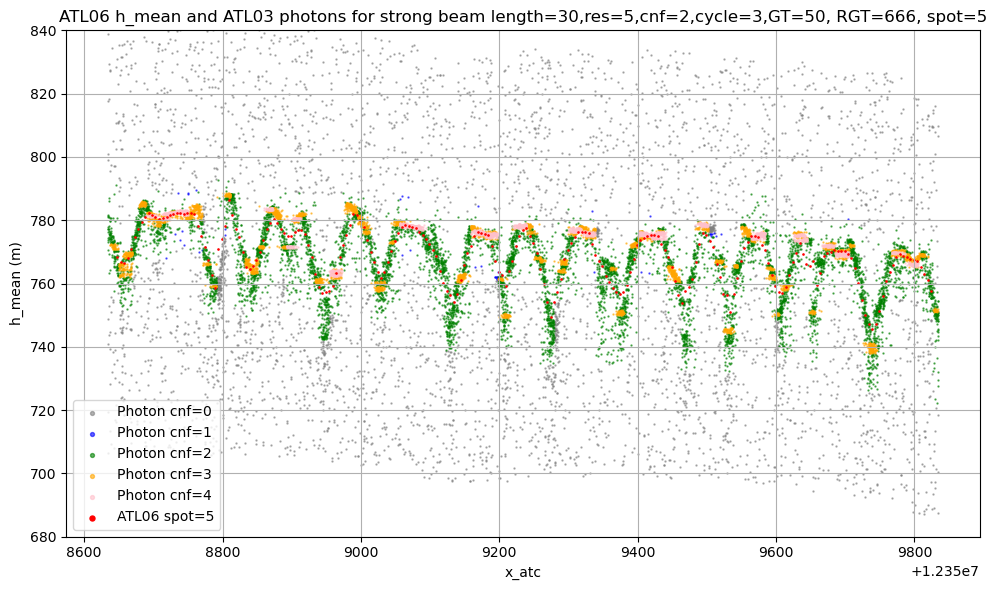

In [6]:
length=30
res=5
cycle=3

parms = {
    "poly": region,
    "srt": 3,       # land ice
    "cnf":2 ,#4,-1
    "ats": 10.0, #20.0,    # 20m along-track spacing
    "cnt": 10,
    "len": length,
    "res": res
}

gdf6 = icesat2.atl06p(parms)

# Request ATL03 data
gdf03x4 = sliderule.run("atl03x", {
    "poly": region,
    "rgt": 666,
    "srt": 3,
    "cnf": -1,
    "cycle": cycle  # wrap cycle in a list
})


# Reproject ATL06 to EPSG:4326 then to EPSG:32622
gdf6 = gdf6.to_crs(epsg=4326)
gdf6 = gdf6.to_crs(epsg=32622)

# Subset ATL06 and ATL03
subset = gdf6[
    (gdf6['gt'] == 50) &
    (gdf6['rgt'] == 666) &
    (gdf6['spot'] == 5) &
    (gdf6['cycle'] == cycle)
]


gdf03x = gdf03x4[
    (gdf03x4['gt'] == 50) &
    (gdf03x4['spot'] == 5)
]

gt_value = subset['gt'].unique()[0]


# Create and save the plot
fig, ax = plt.subplots(figsize=(10, 6))
for cnf_val in sorted(gdf03x['atl03_cnf'].dropna().unique()):
    color = cnf_colors.get(cnf_val, 'black')
    ax.scatter(gdf03x[gdf03x['atl03_cnf'] == cnf_val]['x_atc'],
               gdf03x[gdf03x['atl03_cnf'] == cnf_val]['height'],
               s=0.5, color=color, alpha=0.6, label=f"Photon cnf={cnf_val}")
ax.scatter(subset['x_atc'], subset['h_mean'], s=0.8, color='red',
           label=f"ATL06 spot={subset['spot'].unique()[0]}")
ax.set_xlabel("x_atc")
ax.set_ylabel("h_mean (m)")
# ax.set_title(f"GT={gt_value}, RGT={subset['rgt'].unique()[0]}, Cycle={subset['cycle'].unique()[0]}")
ax.set_title(f"ATL06 h_mean and ATL03 photons for strong beam length={length},res={res},cnf=2,cycle={subset['cycle'].unique()[0]},GT={gt_value}, RGT={subset['rgt'].unique()[0]}, spot={subset['spot'].unique()[0]}")    
ax.set_ylim([680, 840])
ax.grid(True)

ax.legend(markerscale=4)
plt.tight_layout()


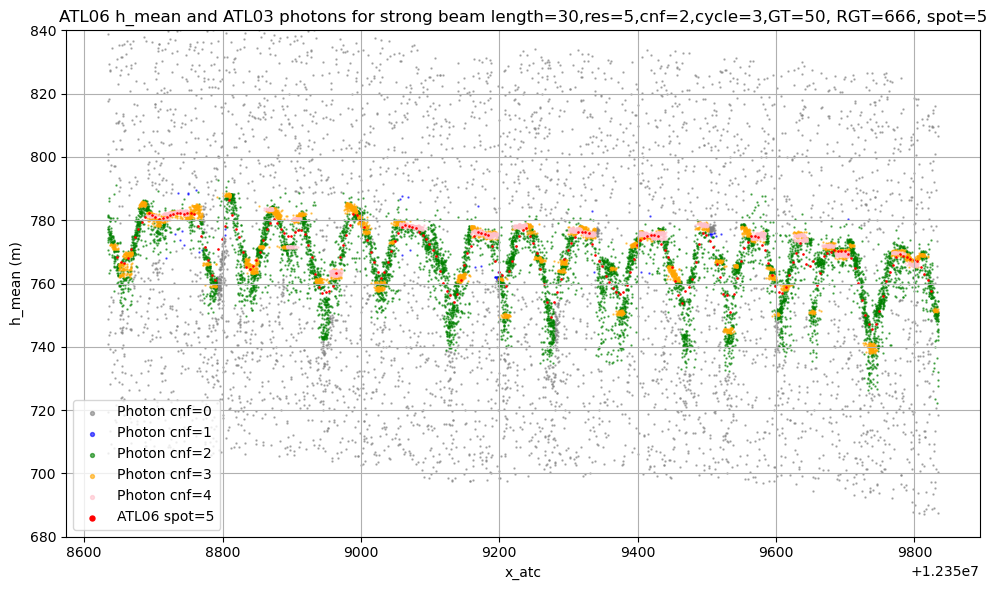

In [7]:
length=30
res=5
cycle=3

parms = {
    "poly": region,
    "srt": 3,       # land ice
    "cnf":2 ,#4,-1
    "ats": 20.0, #20.0,    # 20m along-track spacing
    "cnt": 10,#10
    "len": length,
    "res": res
}

gdf6 = icesat2.atl06p(parms)

# Request ATL03 data
gdf03x4 = sliderule.run("atl03x", {
    "poly": region,
    "rgt": 666,
    "srt": 3,
    "cnf": -1,
    "cycle": cycle,  # wrap cycle in a list
    "keep_id"=True
})


# Reproject ATL06 to EPSG:4326 then to EPSG:32622
gdf6 = gdf6.to_crs(epsg=4326)
gdf6 = gdf6.to_crs(epsg=32622)

# Subset ATL06 and ATL03
subset = gdf6[
    (gdf6['gt'] == 50) &
    (gdf6['rgt'] == 666) &
    (gdf6['spot'] == 5) &
    (gdf6['cycle'] == cycle)
]


gdf03x = gdf03x4[
    (gdf03x4['gt'] == 50) &
    (gdf03x4['spot'] == 5)
]

gt_value = subset['gt'].unique()[0]


# Create and save the plot
fig, ax = plt.subplots(figsize=(10, 6))
for cnf_val in sorted(gdf03x['atl03_cnf'].dropna().unique()):
    color = cnf_colors.get(cnf_val, 'black')
    ax.scatter(gdf03x[gdf03x['atl03_cnf'] == cnf_val]['x_atc'],
               gdf03x[gdf03x['atl03_cnf'] == cnf_val]['height'],
               s=0.5, color=color, alpha=0.6, label=f"Photon cnf={cnf_val}")
ax.scatter(subset['x_atc'], subset['h_mean'], s=0.8, color='red',
           label=f"ATL06 spot={subset['spot'].unique()[0]}")
ax.set_xlabel("x_atc")
ax.set_ylabel("h_mean (m)")
# ax.set_title(f"GT={gt_value}, RGT={subset['rgt'].unique()[0]}, Cycle={subset['cycle'].unique()[0]}")
ax.set_title(f"ATL06 h_mean and ATL03 photons for strong beam length={length},res={res},cnf=2,cycle={subset['cycle'].unique()[0]},GT={gt_value}, RGT={subset['rgt'].unique()[0]}, spot={subset['spot'].unique()[0]}")    
ax.set_ylim([680, 840])
ax.grid(True)

ax.legend(markerscale=4)
plt.tight_layout()


In [8]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(14, 6))

# # Plot 1: pflags vs x_atc
# plt.subplot(1, 2, 1)
# plt.scatter(subset['x_atc'], subset['pflags'], alpha=0.7)
# plt.xlabel('x_atc')
# plt.ylabel('pflags')
# plt.title('pflags vs. x_atc')
# plt.grid(True)

# # Plot 2: h_mean vs x_atc
# plt.subplot(1, 2, 2)
# plt.scatter(subset['x_atc'], subset['h_mean'], alpha=0.7)
# plt.xlabel('x_atc')
# plt.ylabel('h_mean')
# plt.title('h_mean vs. x_atc')
# plt.grid(True)

# plt.tight_layout()
# plt.show()


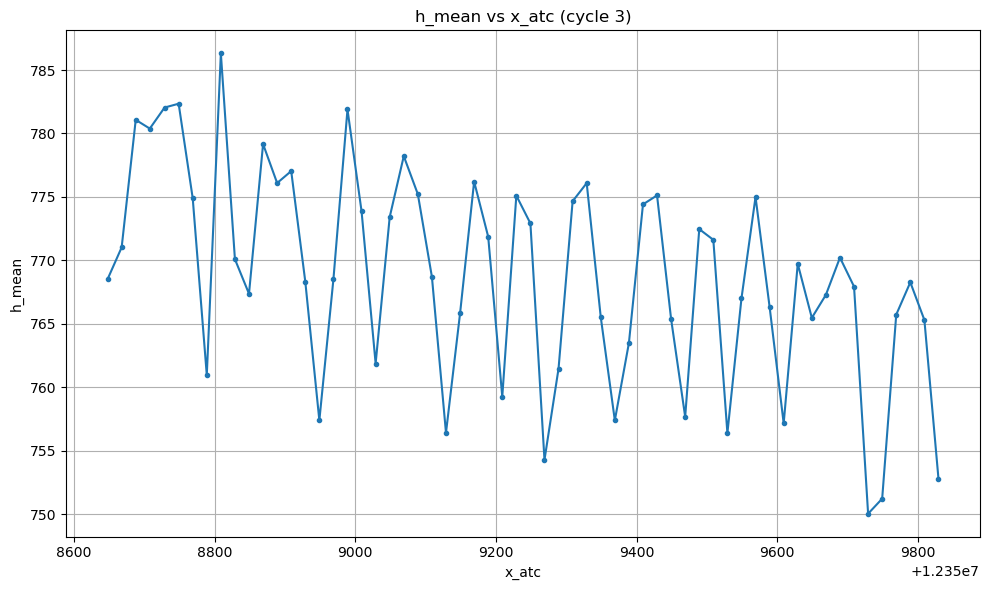

In [9]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
# Plot h_mean vs x_atc
plt.figure(figsize=(10, 6))
plt.plot(subset['x_atc'], subset['h_mean'], marker='o', linestyle='-', markersize=3)
plt.xlabel('x_atc')
plt.ylabel('h_mean')
plt.title(f'h_mean vs x_atc (cycle {cycle})')
plt.grid(True)
plt.tight_layout()
plt.show()

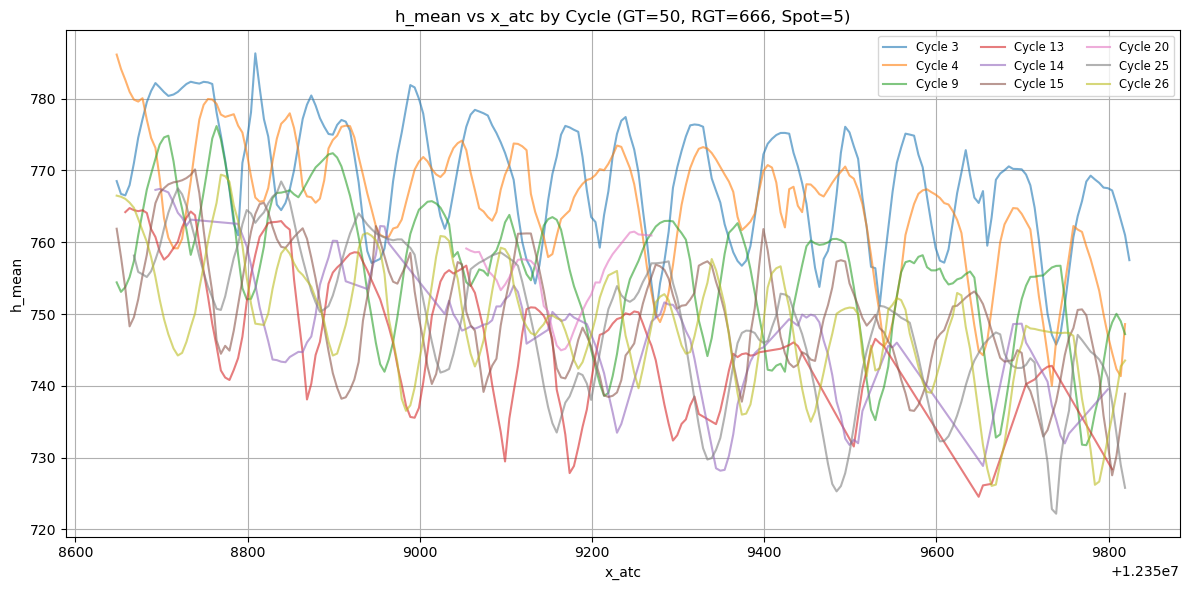

In [25]:

# Extract only relevant subset
subset = gdf6[
    (gdf6['gt'] == 50) &
    (gdf6['rgt'] == 666) &
    (gdf6['spot'] == 5)
]

grouped = subset.groupby('cycle')

plt.figure(figsize=(12, 6))

for cycle_id, group in grouped:
    plt.plot(group['x_atc'], group['h_mean'], alpha=0.6, label=f'Cycle {cycle_id}')

plt.xlabel('x_atc')
plt.ylabel('h_mean')
plt.title('h_mean vs x_atc by Cycle (GT=50, RGT=666, Spot=5)')
plt.grid(True)
plt.legend(fontsize='small', ncol=3)
plt.tight_layout()
plt.show()



In [1]:
# Request ATL03 data
gdf03x4 = sliderule.run("atl03x", {
    "poly": region,
    "rgt": 666,
    "srt": 3,
    "cnf": -1,
    "cycle": cycle,  # wrap cycle in a list
    "keep_id": True##check this
})


In [9]:
length=30
res=5
cycle=3

parms = {
    "poly": region,
    "srt": 3,       # land ice
    "cnf":2 ,#4,-1
    "ats": 10.0, #20.0,    # 20m along-track spacing
    "cnt": 10,
    "len": length,
    "res": res
}

gdf6 = icesat2.atl06p(parms)



import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import CubicSpline

# Your function
def calculate_depth_creavases(subset, cycle, gt):
    # Sort by along-track coordinate
    subset = subset.sort_values('x_atc').reset_index(drop=True)

    # Find all the local minima points (crevasse bottoms)
    subset['is_bottom'] = False
    h_vals = subset['h_mean'].values
    local_minima_indices = np.where((h_vals[1:-1] < h_vals[:-2]) & (h_vals[1:-1] < h_vals[2:]))[0] + 1
    subset.loc[local_minima_indices, 'is_bottom'] = True

    # Detect local maxima (surface points)
    x_vals = subset['x_atc'].values
    surface_indices = np.where((h_vals[1:-1] > h_vals[:-2]) & (h_vals[1:-1] > h_vals[2:]))[0] + 1
    surface_points = [(x_vals[i], h_vals[i]) for i in surface_indices]

    # Fit spline to surface and calculate depth
    if len(surface_points) >= 4:
        surface_points = sorted(surface_points, key=lambda x: x[0])
        surface_df = pd.DataFrame(surface_points, columns=['x', 'h']).drop_duplicates('x').sort_values('x')
        x_surface = surface_df['x'].values
        h_surface = surface_df['h'].values

        if len(x_surface) >= 4:
            spline = CubicSpline(x_surface, h_surface)
            subset['surface_fit'] = spline(subset['x_atc'])
            subset['depth'] = subset['surface_fit'] - subset['h_mean']
        else:
            subset['surface_fit'] = np.nan
            subset['depth'] = np.nan
    else:
        subset['surface_fit'] = np.nan
        subset['depth'] = np.nan

    # Apply depth threshold
    depth_threshold = 2.0  # meters
    subset['is_valid_crevasse'] = (subset['is_bottom']) & (subset['depth'] >= depth_threshold)

    # # Plot crevasse depth
    # plt.figure(figsize=(12, 6))
    # plt.plot(subset['x_atc'], subset['h_mean'], label='h_mean', alpha=0.5)
    # if subset['surface_fit'].notna().any():
    #     plt.plot(subset['x_atc'], subset['surface_fit'], label='Surface fit', linestyle='--')
    # plt.scatter(subset.loc[subset['is_valid_crevasse'], 'x_atc'],
    #             subset.loc[subset['is_valid_crevasse'], 'h_mean'],
    #             color='red', label='Crevasse bottoms')
    # plt.xlabel('x_atc')
    # plt.ylabel('Elevation (m)')
    # plt.title(f'Crevasse Detection for GT{gt} - Cycle {cycle}')
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

    return subset


# === Group by cycle and gt, apply function ===
all_results = []

for (cycle, gt), subset in gdf6.groupby(['cycle', 'gt']):
    result = calculate_depth_creavases(subset.copy(), cycle, gt)
    all_results.append(result)

# Combine results into a single GeoDataFrame
final_result = pd.concat(all_results).sort_index()


In [2]:
import matplotlib.pyplot as plt

# GTs to include
selected_gts = [10, 20, 30, 40, 50, 60]

# Filter for valid crevasses and selected gts
filtered_df = final_result[
    (final_result['is_valid_crevasse'] == True) &
    (final_result['gt'].isin(selected_gts))
]

# Get max depth for y-axis limit
max_depth = filtered_df['depth'].max()

# Get unique cycles
unique_cycles = sorted(filtered_df['cycle'].unique())

# Plot for each cycle
for cycle in unique_cycles:
    cycle_df = filtered_df[filtered_df['cycle'] == cycle]
    
    plt.figure(figsize=(8, 5))
    plt.scatter(cycle_df['gt'], cycle_df['depth'], alpha=0.7, s=15)
    plt.title(f'Cycle {cycle}')
    plt.xlabel('gt')
    plt.ylabel('depth')
    plt.xticks(selected_gts)
    plt.ylim(0, max_depth)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [16]:
import matplotlib.pyplot as plt
from pptx import Presentation
from pptx.util import Inches
import os

# GTs to include
selected_gts = [10, 20, 30, 40, 50, 60]

# Filter DataFrame
filtered_df = final_result[
    (final_result['is_valid_crevasse'] == True) &
    (final_result['gt'].isin(selected_gts))
]

# Get max depth for y-axis limit
max_depth = filtered_df['depth'].max()

# Unique cycles
unique_cycles = sorted(filtered_df['cycle'].unique())

# Temporary folder for images
img_dir = "temp_cycle_plots"
os.makedirs(img_dir, exist_ok=True)

# Create a new PowerPoint presentation
prs = Presentation()
blank_slide_layout = prs.slide_layouts[6]  # Blank layout

# Generate and save each plot
for cycle in unique_cycles:
    cycle_df = filtered_df[filtered_df['cycle'] == cycle]

    # Skip empty groups
    if cycle_df.empty:
        continue

    # Plot and save
    plt.figure(figsize=(8, 5))
    plt.scatter(cycle_df['gt'], cycle_df['depth'], alpha=0.7, s=15)
    plt.title(f'Cycle {cycle}')
    plt.xlabel('gt')
    plt.ylabel('crevasse depth')
    plt.xticks(selected_gts)
    plt.ylim(0, max_depth)
    plt.grid(True)
    plt.tight_layout()
    img_path = os.path.join(img_dir, f"cycle_{cycle}.png")
    plt.savefig(img_path, dpi=150)
    plt.close()

    # Add slide with image
    slide = prs.slides.add_slide(blank_slide_layout)
    slide.shapes.add_picture(img_path, Inches(1), Inches(1), width=Inches(8), height=Inches(5.5))

# Save PowerPoint
pptx_output = "/home/jovyan/Glacier_preprocessing/Greenland/latestupdatedcode/Crevasses_depth_plot.pptx"
prs.save(pptx_output)

print(f"Saved presentation: {pptx_output}")


Saved presentation: /home/jovyan/Glacier_preprocessing/Greenland/latestupdatedcode/Crevasses_depth_plot.pptx
